# Playing with fake artefact and RESTORE

## Setup

In [33]:
import numpy as np
import matplotlib.pyplot as pl
import dipy.reconst.dti as dti
from dipy.sims.voxel import single_tensor 
from dipy.io.gradients import read_bvals_bvecs
from dipy.core.gradients import gradient_table
from scipy.spatial.transform import Rotation as R

In [25]:
# rootdir="/data/hu_paquette/Downloads/notebook_from_home/"
bvals, bvecs = read_bvals_bvecs("dirscheme_60_eddy.bval", "dirscheme_60_eddy.bvec")
gtab = gradient_table(np.concatenate(([0], bvals)), np.concatenate(([[0,0,0]], bvecs)))

In [26]:
# create some evecs
rot = R.from_rotvec((np.pi/6) * np.array([1,2,3])/np.linalg.norm(np.array([1,2,3])))
evecs = rot.apply(np.eye(3))

In [27]:
# evals (in mm^2/s)
evals = np.array([1.7, 0.5, 0.3])*1e-3

In [157]:
def angle_between(v1, v2):
    # assumes norm=1
    # in radians
    return np.arccos(np.clip(np.dot(v1, v2), -1.0, 1.0))

def rad2deg(rad):
    return (180/np.pi)*rad

def dist_deg_antipodal(v1,v2):
    d1 = angle_between(v1, v2)
    d2 = angle_between(v1, -v2)
    return rad2deg(min(d1,d2))

In [244]:
def errors(gt_fa, gt_md, gt_evals, gt_evecs, fas, mds, evalss, evecss):
    fa_errs = gt_fa - fas
    fa_err_mean = fa_errs.mean()
    fa_err_std = fa_errs.std()
    
    md_errs = gt_md - mds
    md_err_mean = md_errs.mean()*1e3
    md_err_std = md_errs.std()*1e3
    
    evals_errs = gt_evals[:, None] - evalss
    evals_err_mean = evals_errs.mean(axis=1)*1e3
    evals_err_std = evals_errs.std(axis=1)*1e3
    
    dist_e0 = [dist_deg_antipodal(evecss[:, 0, i], gt_evecs[:, 0]) for i in range(evecss.shape[2])]
    dist_e1 = [dist_deg_antipodal(evecss[:, 1, i], gt_evecs[:, 1]) for i in range(evecss.shape[2])]
    dist_e2 = [dist_deg_antipodal(evecss[:, 2, i], gt_evecs[:, 2]) for i in range(evecss.shape[2])]
    
    evecs_err_mean = np.array([np.array(dist_e0).mean(), np.array(dist_e1).mean(), np.array(dist_e2).mean()])
    evecs_err_std = np.array([np.array(dist_e0).std(), np.array(dist_e1).std(), np.array(dist_e2).std()])
    
    return fa_err_mean, md_err_mean, evals_err_mean, evecs_err_mean, fa_err_std, md_err_std, evals_err_std, evecs_err_std


## SIMULATE: WLS vs RESTORE reconstruction with and without artefact

In [187]:
# simulate impact of artefact in a few directions with and without restore on DTI data
def simulate(gtab, evals, evecs, snr, noise_trial, broken_idx):
    # signal will be generated from dti model with evals and evecs
    # using gtab
    # there will be noise_trial repetition of rician "noise" with sigma 1/snr
    # for each noise trial the dti model with wls and restore will be fitted
    # we store the fa, md, evals and the evecs angular error
    # for each noise trial there will also be simulated artefact by reducing by half the after noise intensity of voxel with idx broken_idx
    # this will be fitted with wls and restore and the same metrics stored
    # for both experiment, the restore method will receive ground truth sigma = 1/snr
    
    # noiseless
    gt_noiseless = single_tensor(gtab, S0=1, evals=evals, evecs=evecs, snr=None)
    dti_wls_gt = dti.TensorModel(gtab, fit_method='WLS')
    fit_wls_gt = dti_wls_gt.fit(gt_noiseless)
    gt_fa = fit_wls_gt.fa
    gt_md = fit_wls_gt.md
    

    noisy = np.zeros((gtab.bvals.shape[0], noise_trial))
    noisy_artefact = np.zeros((gtab.bvals.shape[0], noise_trial))
    for i in range(noise_trial):
        noisy[:, i] = single_tensor(gtab, S0=1, evals=evals, evecs=evecs, snr=snr)
        # introduce "artefact" by reducing by half the noisy intensity of broken_idx
        noisy_artefact[:, i] = noisy[:,i].copy()
        noisy_artefact[broken_idx, i] *= 0.5
    
    # WLS noisy fit
    noisy_wls_evals = np.zeros((3, noise_trial))
    noisy_wls_evecs = np.zeros((3, 3, noise_trial))
    noisy_wls_fa = np.zeros((noise_trial))
    noisy_wls_md = np.zeros((noise_trial))
    for i in range(noise_trial):
        dti_wls = dti.TensorModel(gtab, fit_method='WLS')
        fit_wls = dti_wls.fit(noisy[:,i])
        noisy_wls_evals[:, i] = fit_wls.evals
        noisy_wls_evecs[:, :, i] = fit_wls.evecs
        noisy_wls_fa[i] = fit_wls.fa
        noisy_wls_md[i] = fit_wls.md
    
    # WLS noisy artefact fit
    noisy_artefact_wls_evals = np.zeros((3, noise_trial))
    noisy_artefact_wls_evecs = np.zeros((3, 3, noise_trial))
    noisy_artefact_wls_fa = np.zeros((noise_trial))
    noisy_artefact_wls_md = np.zeros((noise_trial))
    for i in range(noise_trial):
        dti_wls = dti.TensorModel(gtab, fit_method='WLS')
        fit_wls = dti_wls.fit(noisy_artefact[:,i])
        noisy_artefact_wls_evals[:, i] = fit_wls.evals
        noisy_artefact_wls_evecs[:, :, i] = fit_wls.evecs
        noisy_artefact_wls_fa[i] = fit_wls.fa
        noisy_artefact_wls_md[i] = fit_wls.md
    
    # RESTORE noisy fit
    noisy_res_evals = np.zeros((3, noise_trial))
    noisy_res_evecs = np.zeros((3, 3, noise_trial))
    noisy_res_fa = np.zeros((noise_trial))
    noisy_res_md = np.zeros((noise_trial))
    for i in range(noise_trial):
        dti_res = dti.TensorModel(gtab, fit_method='RESTORE', sigma=1/snr)
        fit_res = dti_res.fit(noisy[:,i])
        noisy_res_evals[:, i] = fit_res.evals
        noisy_res_evecs[:, :, i] = fit_res.evecs
        noisy_res_fa[i] = fit_res.fa
        noisy_res_md[i] = fit_res.md
        
    # RESTORE noisy artefact fit
    noisy_artefact_res_evals = np.zeros((3, noise_trial))
    noisy_artefact_res_evecs = np.zeros((3, 3, noise_trial))
    noisy_artefact_res_fa = np.zeros((noise_trial))
    noisy_artefact_res_md = np.zeros((noise_trial))
    for i in range(noise_trial):
        dti_res = dti.TensorModel(gtab, fit_method='RESTORE', sigma=1/snr)
        fit_res = dti_res.fit(noisy_artefact[:,i])
        noisy_artefact_res_evals[:, i] = fit_res.evals
        noisy_artefact_res_evecs[:, :, i] = fit_res.evecs
        noisy_artefact_res_fa[i] = fit_res.fa
        noisy_artefact_res_md[i] = fit_res.md
        
    noisy_wls_fa_err_mean, noisy_wls_md_err_mean, noisy_wls_evals_err_mean, noisy_wls_evecs_err_mean, noisy_wls_fa_err_std, noisy_wls_md_err_std, noisy_wls_evals_err_std, noisy_wls_evecs_err_std = errors(gt_fa, gt_md, evals, evecs, noisy_wls_fa, noisy_wls_md, noisy_wls_evals, noisy_wls_evecs)

    noisy_artefact_wls_fa_err_mean, noisy_artefact_wls_md_err_mean, noisy_artefact_wls_evals_err_mean, noisy_artefact_wls_evecs_err_mean, noisy_artefact_wls_fa_err_std, noisy_artefact_wls_md_err_std, noisy_artefact_wls_evals_err_std, noisy_artefact_wls_evecs_err_std = errors(gt_fa, gt_md, evals, evecs, noisy_artefact_wls_fa, noisy_artefact_wls_md, noisy_artefact_wls_evals, noisy_artefact_wls_evecs)

    noisy_res_fa_err_mean, noisy_res_md_err_mean, noisy_res_evals_err_mean, noisy_res_evecs_err_mean, noisy_res_fa_err_std, noisy_res_md_err_std, noisy_res_evals_err_std, noisy_res_evecs_err_std = errors(gt_fa, gt_md, evals, evecs, noisy_res_fa, noisy_res_md, noisy_res_evals, noisy_res_evecs)

    noisy_artefact_res_fa_err_mean, noisy_artefact_res_md_err_mean, noisy_artefact_res_evals_err_mean, noisy_artefact_res_evecs_err_mean, noisy_artefact_res_fa_err_std, noisy_artefact_res_md_err_std, noisy_artefact_res_evals_err_std, noisy_artefact_res_evecs_err_std = errors(gt_fa, gt_md, evals, evecs, noisy_artefact_res_fa, noisy_artefact_res_md, noisy_artefact_res_evals, noisy_artefact_res_evecs)        
        
    return (noisy_wls_fa_err_mean, noisy_wls_md_err_mean, noisy_wls_evals_err_mean, noisy_wls_evecs_err_mean, noisy_wls_fa_err_std, noisy_wls_md_err_std, noisy_wls_evals_err_std, noisy_wls_evecs_err_std), (noisy_artefact_wls_fa_err_mean, noisy_artefact_wls_md_err_mean, noisy_artefact_wls_evals_err_mean, noisy_artefact_wls_evecs_err_mean, noisy_artefact_wls_fa_err_std, noisy_artefact_wls_md_err_std, noisy_artefact_wls_evals_err_std, noisy_artefact_wls_evecs_err_std), (noisy_res_fa_err_mean, noisy_res_md_err_mean, noisy_res_evals_err_mean, noisy_res_evecs_err_mean, noisy_res_fa_err_std, noisy_res_md_err_std, noisy_res_evals_err_std, noisy_res_evecs_err_std), (noisy_artefact_res_fa_err_mean, noisy_artefact_res_md_err_mean, noisy_artefact_res_evals_err_mean, noisy_artefact_res_evecs_err_mean, noisy_artefact_res_fa_err_std, noisy_artefact_res_md_err_std, noisy_artefact_res_evals_err_std, noisy_artefact_res_evecs_err_std)   
        

## WLS vs RESTORE on non-artefact data, multiple SNR

In [197]:
# pure effect of SNR
snrs = [5, 7.5, 10, 15, 20, 30, 50, 1000]
results = []
for snr in snrs:
    noisy_wls, noisy_artefact_wls, noisy_res, noisy_artefact_res = simulate(gtab, evals, evecs, snr, 100, [])
    results.append((noisy_wls, noisy_artefact_wls, noisy_res, noisy_artefact_res))

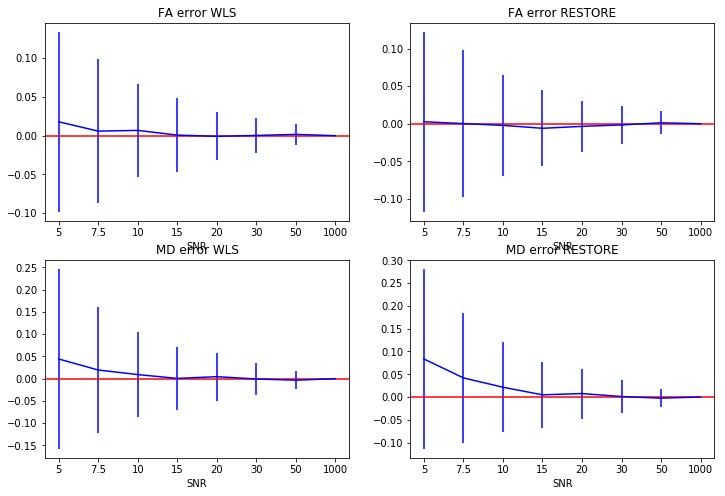

In [222]:
pl.figure(figsize=(12, 8))
pl.subplot(2,2,1)
pl.title('FA error WLS')
data = [[r[0][0]] for r in results]
data_std = [[r[0][4]] for r in results]
pl.errorbar(range(len(snrs)), data, yerr=np.array(data_std), color='blue')
pl.axhline(0, color='red')
pl.xticks(range(len(snrs)), snrs)
pl.xlabel('SNR')

pl.subplot(2,2,2)
pl.title('FA error RESTORE')
data = [[r[2][0]] for r in results]
data_std = [[r[2][4]] for r in results]
pl.errorbar(range(len(snrs)), data, yerr=np.array(data_std), color='blue')
pl.axhline(0, color='red')
pl.xticks(range(len(snrs)), snrs)
pl.xlabel('SNR')

pl.subplot(2,2,3)
pl.title('MD error WLS')
data = [[r[0][1]] for r in results]
data_std = [[r[0][5]] for r in results]
pl.errorbar(range(len(snrs)), data, yerr=np.array(data_std), color='blue')
pl.axhline(0, color='red')
pl.xticks(range(len(snrs)), snrs)
pl.xlabel('SNR')

pl.subplot(2,2,4)
pl.title('MD error RESTORE')
data = [[r[2][1]] for r in results]
data_std = [[r[2][5]] for r in results]
pl.errorbar(range(len(snrs)), data, yerr=np.array(data_std), color='blue')
pl.axhline(0, color='red')
pl.xticks(range(len(snrs)), snrs)
pl.xlabel('SNR')

pl.show()

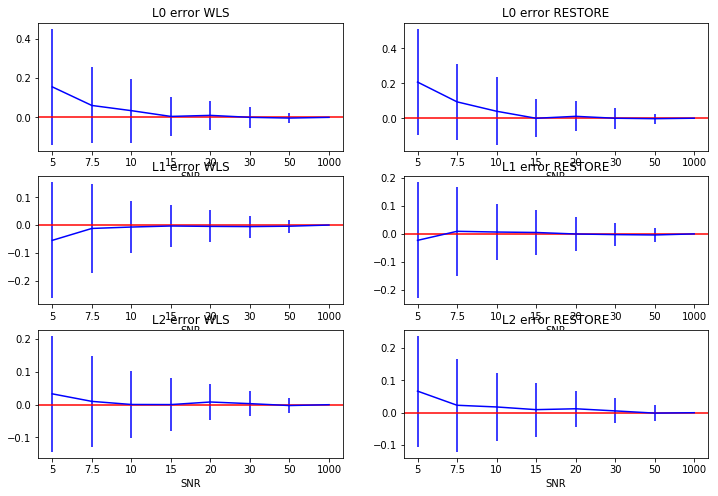

In [233]:
pl.figure(figsize=(12, 8))
pl.subplot(3,2,1)
pl.title('L0 error WLS')
data = [[r[0][2][0]] for r in results]
data_std = [[r[0][6][0]] for r in results]
pl.errorbar(range(len(snrs)), data, yerr=np.array(data_std), color='blue')
pl.axhline(0, color='red')
pl.xticks(range(len(snrs)), snrs)
pl.xlabel('SNR')

pl.subplot(3,2,2)
pl.title('L0 error RESTORE')
data = [[r[2][2][0]] for r in results]
data_std = [[r[2][6][0]] for r in results]
pl.errorbar(range(len(snrs)), data, yerr=np.array(data_std), color='blue')
pl.axhline(0, color='red')
pl.xticks(range(len(snrs)), snrs)
pl.xlabel('SNR')

pl.subplot(3,2,3)
pl.title('L1 error WLS')
data = [[r[0][2][1]] for r in results]
data_std = [[r[0][6][1]] for r in results]
pl.errorbar(range(len(snrs)), data, yerr=np.array(data_std), color='blue')
pl.axhline(0, color='red')
pl.xticks(range(len(snrs)), snrs)
pl.xlabel('SNR')

pl.subplot(3,2,4)
pl.title('L1 error RESTORE')
data = [[r[2][2][1]] for r in results]
data_std = [[r[2][6][1]] for r in results]
pl.errorbar(range(len(snrs)), data, yerr=np.array(data_std), color='blue')
pl.axhline(0, color='red')
pl.xticks(range(len(snrs)), snrs)
pl.xlabel('SNR')

pl.subplot(3,2,5)
pl.title('L2 error WLS')
data = [[r[0][2][2]] for r in results]
data_std = [[r[0][6][2]] for r in results]
pl.errorbar(range(len(snrs)), data, yerr=np.array(data_std), color='blue')
pl.axhline(0, color='red')
pl.xticks(range(len(snrs)), snrs)
pl.xlabel('SNR')

pl.subplot(3,2,6)
pl.title('L2 error RESTORE')
data = [[r[2][2][2]] for r in results]
data_std = [[r[2][6][2]] for r in results]
pl.errorbar(range(len(snrs)), data, yerr=np.array(data_std), color='blue')
pl.axhline(0, color='red')
pl.xticks(range(len(snrs)), snrs)
pl.xlabel('SNR')

pl.show()

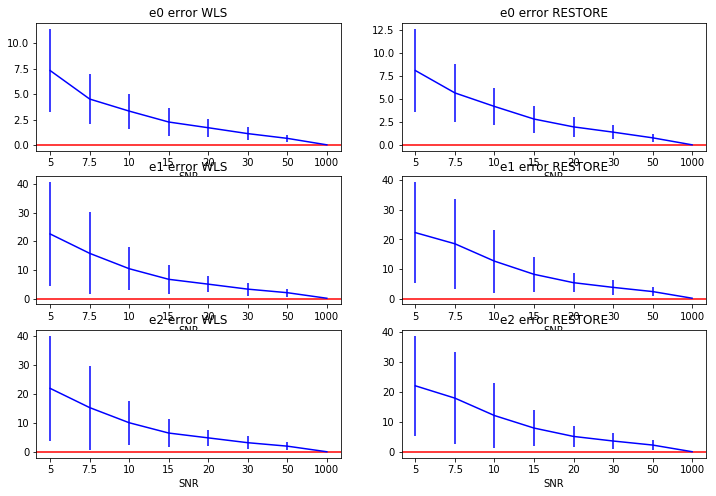

In [234]:
pl.figure(figsize=(12, 8))
pl.subplot(3,2,1)
pl.title('e0 error WLS')
data = [[r[0][3][0]] for r in results]
data_std = [[r[0][7][0]] for r in results]
pl.errorbar(range(len(snrs)), data, yerr=np.array(data_std), color='blue')
pl.axhline(0, color='red')
pl.xticks(range(len(snrs)), snrs)
pl.xlabel('SNR')

pl.subplot(3,2,2)
pl.title('e0 error RESTORE')
data = [[r[2][3][0]] for r in results]
data_std = [[r[2][7][0]] for r in results]
pl.errorbar(range(len(snrs)), data, yerr=np.array(data_std), color='blue')
pl.axhline(0, color='red')
pl.xticks(range(len(snrs)), snrs)
pl.xlabel('SNR')

pl.subplot(3,2,3)
pl.title('e1 error WLS')
data = [[r[0][3][1]] for r in results]
data_std = [[r[0][7][1]] for r in results]
pl.errorbar(range(len(snrs)), data, yerr=np.array(data_std), color='blue')
pl.axhline(0, color='red')
pl.xticks(range(len(snrs)), snrs)
pl.xlabel('SNR')

pl.subplot(3,2,4)
pl.title('e1 error RESTORE')
data = [[r[2][3][1]] for r in results]
data_std = [[r[2][7][1]] for r in results]
pl.errorbar(range(len(snrs)), data, yerr=np.array(data_std), color='blue')
pl.axhline(0, color='red')
pl.xticks(range(len(snrs)), snrs)
pl.xlabel('SNR')

pl.subplot(3,2,5)
pl.title('e2 error WLS')
data = [[r[0][3][2]] for r in results]
data_std = [[r[0][7][2]] for r in results]
pl.errorbar(range(len(snrs)), data, yerr=np.array(data_std), color='blue')
pl.axhline(0, color='red')
pl.xticks(range(len(snrs)), snrs)
pl.xlabel('SNR')

pl.subplot(3,2,6)
pl.title('e2 error RESTORE')
data = [[r[2][3][2]] for r in results]
data_std = [[r[2][7][2]] for r in results]
pl.errorbar(range(len(snrs)), data, yerr=np.array(data_std), color='blue')
pl.axhline(0, color='red')
pl.xticks(range(len(snrs)), snrs)
pl.xlabel('SNR')

pl.show()

## WLS vs RESTORE on SNR=30 data, increasing number of artefact volume

In [239]:
# pure effect of N artefact
N_artefact = range(0, 11)
results = []
for N in N_artefact:
    broken_idx = [i for i in range(10,10+N)]
    noisy_wls, noisy_artefact_wls, noisy_res, noisy_artefact_res = simulate(gtab, evals, evecs, 30, 100, broken_idx)
    results.append((noisy_wls, noisy_artefact_wls, noisy_res, noisy_artefact_res))

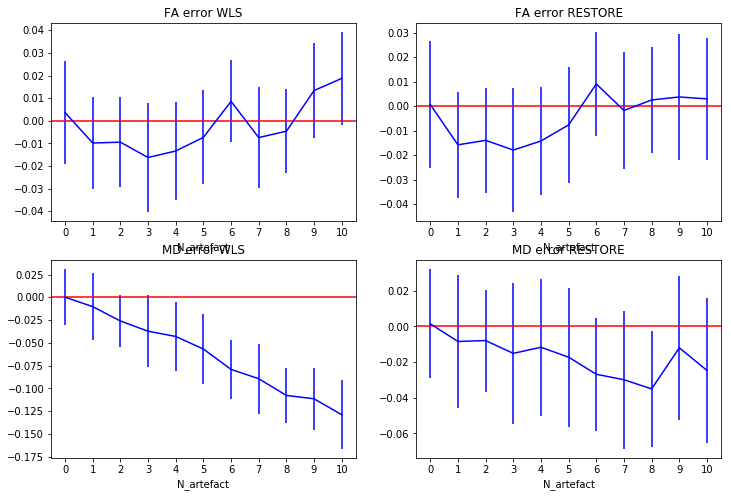

In [240]:
pl.figure(figsize=(12, 8))
pl.subplot(2,2,1)
pl.title('FA error WLS')
data = [[r[1][0]] for r in results]
data_std = [[r[1][4]] for r in results]
pl.errorbar(range(len(N_artefact)), data, yerr=np.array(data_std), color='blue')
pl.axhline(0, color='red')
pl.xticks(range(len(N_artefact)), N_artefact)
pl.xlabel('N_artefact')

pl.subplot(2,2,2)
pl.title('FA error RESTORE')
data = [[r[3][0]] for r in results]
data_std = [[r[3][4]] for r in results]
pl.errorbar(range(len(N_artefact)), data, yerr=np.array(data_std), color='blue')
pl.axhline(0, color='red')
pl.xticks(range(len(N_artefact)), N_artefact)
pl.xlabel('N_artefact')

pl.subplot(2,2,3)
pl.title('MD error WLS')
data = [[r[1][1]] for r in results]
data_std = [[r[1][5]] for r in results]
pl.errorbar(range(len(N_artefact)), data, yerr=np.array(data_std), color='blue')
pl.axhline(0, color='red')
pl.xticks(range(len(N_artefact)), N_artefact)
pl.xlabel('N_artefact')

pl.subplot(2,2,4)
pl.title('MD error RESTORE')
data = [[r[3][1]] for r in results]
data_std = [[r[3][5]] for r in results]
pl.errorbar(range(len(N_artefact)), data, yerr=np.array(data_std), color='blue')
pl.axhline(0, color='red')
pl.xticks(range(len(N_artefact)), N_artefact)
pl.xlabel('N_artefact')

pl.show()

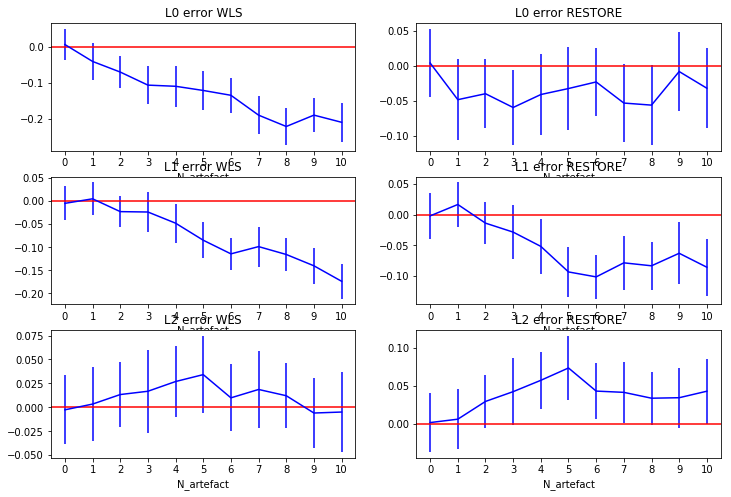

In [241]:
pl.figure(figsize=(12, 8))
pl.subplot(3,2,1)
pl.title('L0 error WLS')
data = [[r[1][2][0]] for r in results]
data_std = [[r[1][6][0]] for r in results]
pl.errorbar(range(len(N_artefact)), data, yerr=np.array(data_std), color='blue')
pl.axhline(0, color='red')
pl.xticks(range(len(N_artefact)), N_artefact)
pl.xlabel('N_artefact')

pl.subplot(3,2,2)
pl.title('L0 error RESTORE')
data = [[r[3][2][0]] for r in results]
data_std = [[r[3][6][0]] for r in results]
pl.errorbar(range(len(N_artefact)), data, yerr=np.array(data_std), color='blue')
pl.axhline(0, color='red')
pl.xticks(range(len(N_artefact)), N_artefact)
pl.xlabel('N_artefact')

pl.subplot(3,2,3)
pl.title('L1 error WLS')
data = [[r[1][2][1]] for r in results]
data_std = [[r[1][6][1]] for r in results]
pl.errorbar(range(len(N_artefact)), data, yerr=np.array(data_std), color='blue')
pl.axhline(0, color='red')
pl.xticks(range(len(N_artefact)), N_artefact)
pl.xlabel('N_artefact')

pl.subplot(3,2,4)
pl.title('L1 error RESTORE')
data = [[r[3][2][1]] for r in results]
data_std = [[r[3][6][1]] for r in results]
pl.errorbar(range(len(N_artefact)), data, yerr=np.array(data_std), color='blue')
pl.axhline(0, color='red')
pl.xticks(range(len(N_artefact)), N_artefact)
pl.xlabel('N_artefact')

pl.subplot(3,2,5)
pl.title('L2 error WLS')
data = [[r[1][2][2]] for r in results]
data_std = [[r[1][6][2]] for r in results]
pl.errorbar(range(len(N_artefact)), data, yerr=np.array(data_std), color='blue')
pl.axhline(0, color='red')
pl.xticks(range(len(N_artefact)), N_artefact)
pl.xlabel('N_artefact')

pl.subplot(3,2,6)
pl.title('L2 error RESTORE')
data = [[r[3][2][2]] for r in results]
data_std = [[r[3][6][2]] for r in results]
pl.errorbar(range(len(N_artefact)), data, yerr=np.array(data_std), color='blue')
pl.axhline(0, color='red')
pl.xticks(range(len(N_artefact)), N_artefact)
pl.xlabel('N_artefact')

pl.show()

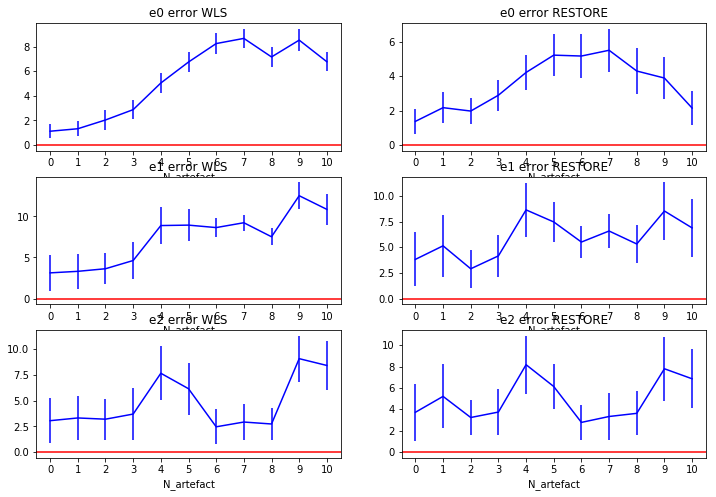

In [246]:
pl.figure(figsize=(12, 8))
pl.subplot(3,2,1)
pl.title('e0 error WLS')
data = [[r[1][3][0]] for r in results]
data_std = [[r[1][7][0]] for r in results]
pl.errorbar(range(len(N_artefact)), data, yerr=np.array(data_std), color='blue')
pl.axhline(0, color='red')
pl.xticks(range(len(N_artefact)), N_artefact)
pl.xlabel('N_artefact')

pl.subplot(3,2,2)
pl.title('e0 error RESTORE')
data = [[r[3][3][0]] for r in results]
data_std = [[r[3][7][0]] for r in results]
pl.errorbar(range(len(N_artefact)), data, yerr=np.array(data_std), color='blue')
pl.axhline(0, color='red')
pl.xticks(range(len(N_artefact)), N_artefact)
pl.xlabel('N_artefact')

pl.subplot(3,2,3)
pl.title('e1 error WLS')
data = [[r[1][3][1]] for r in results]
data_std = [[r[1][7][1]] for r in results]
pl.errorbar(range(len(N_artefact)), data, yerr=np.array(data_std), color='blue')
pl.axhline(0, color='red')
pl.xticks(range(len(N_artefact)), N_artefact)
pl.xlabel('N_artefact')

pl.subplot(3,2,4)
pl.title('e1 error RESTORE')
data = [[r[3][3][1]] for r in results]
data_std = [[r[3][7][1]] for r in results]
pl.errorbar(range(len(N_artefact)), data, yerr=np.array(data_std), color='blue')
pl.axhline(0, color='red')
pl.xticks(range(len(N_artefact)), N_artefact)
pl.xlabel('N_artefact')

pl.subplot(3,2,5)
pl.title('e2 error WLS')
data = [[r[1][3][2]] for r in results]
data_std = [[r[1][7][2]] for r in results]
pl.errorbar(range(len(N_artefact)), data, yerr=np.array(data_std), color='blue')
pl.axhline(0, color='red')
pl.xticks(range(len(N_artefact)), N_artefact)
pl.xlabel('N_artefact')

pl.subplot(3,2,6)
pl.title('e2 error RESTORE')
data = [[r[3][3][2]] for r in results]
data_std = [[r[3][7][2]] for r in results]
pl.errorbar(range(len(N_artefact)), data, yerr=np.array(data_std), color='blue')
pl.axhline(0, color='red')
pl.xticks(range(len(N_artefact)), N_artefact)
pl.xlabel('N_artefact')

pl.show()

array([0.19272546, 0.06898927, 0.72797445, 0.65025928, 0.31777417,
       0.0293902 ])

## SIMULATE2: WLS vs RESTORE reconstruction with and without removing a few volume

In [266]:
# simulate impact of data-removal in a few directions with and without restore on DTI data
def simulate2(gtab, evals, evecs, snr, noise_trial, broken_idx):
    # signal will be generated from dti model with evals and evecs
    # using gtab
    # there will be noise_trial repetition of rician "noise" with sigma 1/snr
    # for each noise trial the dti model with wls and restore will be fitted
    # we store the fa, md, evals and the evecs angular error
    # for each noise trial there will also be removed volumes with idx broken_idx
    # this will be fitted with wls and restore and the same metrics stored
    # for both experiment, the restore method will receive ground truth sigma = 1/snr
    
    # noiseless
    gt_noiseless = single_tensor(gtab, S0=1, evals=evals, evecs=evecs, snr=None)
    dti_wls_gt = dti.TensorModel(gtab, fit_method='WLS')
    fit_wls_gt = dti_wls_gt.fit(gt_noiseless)
    gt_fa = fit_wls_gt.fa
    gt_md = fit_wls_gt.md
    
    # build reduced gtab
    tmpbvals = np.concatenate(([0], bvals))
    tmpbvecs = np.concatenate(([[0,0,0]], bvecs))
    tokeep = sorted(list(set(range(tmpbvecs.shape[0])).difference(set(broken_idx))))
    gtab2 = gradient_table(tmpbvals[tokeep], tmpbvecs[tokeep])
    

    noisy = np.zeros((gtab.bvals.shape[0], noise_trial))
    noisy_artefact = np.zeros((gtab2.bvals.shape[0], noise_trial))
    for i in range(noise_trial):
        noisy[:, i] = single_tensor(gtab, S0=1, evals=evals, evecs=evecs, snr=snr)
        # remove broken_idx
        noisy_artefact[:, i] = noisy[tokeep, i]
    
    # WLS noisy fit
    noisy_wls_evals = np.zeros((3, noise_trial))
    noisy_wls_evecs = np.zeros((3, 3, noise_trial))
    noisy_wls_fa = np.zeros((noise_trial))
    noisy_wls_md = np.zeros((noise_trial))
    for i in range(noise_trial):
        dti_wls = dti.TensorModel(gtab, fit_method='WLS')
        fit_wls = dti_wls.fit(noisy[:,i])
        noisy_wls_evals[:, i] = fit_wls.evals
        noisy_wls_evecs[:, :, i] = fit_wls.evecs
        noisy_wls_fa[i] = fit_wls.fa
        noisy_wls_md[i] = fit_wls.md
    
    # WLS noisy artefact fit
    noisy_artefact_wls_evals = np.zeros((3, noise_trial))
    noisy_artefact_wls_evecs = np.zeros((3, 3, noise_trial))
    noisy_artefact_wls_fa = np.zeros((noise_trial))
    noisy_artefact_wls_md = np.zeros((noise_trial))
    for i in range(noise_trial):
        dti_wls = dti.TensorModel(gtab2, fit_method='WLS')
        fit_wls = dti_wls.fit(noisy_artefact[:,i])
        noisy_artefact_wls_evals[:, i] = fit_wls.evals
        noisy_artefact_wls_evecs[:, :, i] = fit_wls.evecs
        noisy_artefact_wls_fa[i] = fit_wls.fa
        noisy_artefact_wls_md[i] = fit_wls.md
    
    # RESTORE noisy fit
    noisy_res_evals = np.zeros((3, noise_trial))
    noisy_res_evecs = np.zeros((3, 3, noise_trial))
    noisy_res_fa = np.zeros((noise_trial))
    noisy_res_md = np.zeros((noise_trial))
    for i in range(noise_trial):
        dti_res = dti.TensorModel(gtab, fit_method='RESTORE', sigma=1/snr)
        fit_res = dti_res.fit(noisy[:,i])
        noisy_res_evals[:, i] = fit_res.evals
        noisy_res_evecs[:, :, i] = fit_res.evecs
        noisy_res_fa[i] = fit_res.fa
        noisy_res_md[i] = fit_res.md
        
    # RESTORE noisy artefact fit
    noisy_artefact_res_evals = np.zeros((3, noise_trial))
    noisy_artefact_res_evecs = np.zeros((3, 3, noise_trial))
    noisy_artefact_res_fa = np.zeros((noise_trial))
    noisy_artefact_res_md = np.zeros((noise_trial))
    for i in range(noise_trial):
        dti_res = dti.TensorModel(gtab2, fit_method='RESTORE', sigma=1/snr)
        fit_res = dti_res.fit(noisy_artefact[:,i])
        noisy_artefact_res_evals[:, i] = fit_res.evals
        noisy_artefact_res_evecs[:, :, i] = fit_res.evecs
        noisy_artefact_res_fa[i] = fit_res.fa
        noisy_artefact_res_md[i] = fit_res.md
        
    noisy_wls_fa_err_mean, noisy_wls_md_err_mean, noisy_wls_evals_err_mean, noisy_wls_evecs_err_mean, noisy_wls_fa_err_std, noisy_wls_md_err_std, noisy_wls_evals_err_std, noisy_wls_evecs_err_std = errors(gt_fa, gt_md, evals, evecs, noisy_wls_fa, noisy_wls_md, noisy_wls_evals, noisy_wls_evecs)

    noisy_artefact_wls_fa_err_mean, noisy_artefact_wls_md_err_mean, noisy_artefact_wls_evals_err_mean, noisy_artefact_wls_evecs_err_mean, noisy_artefact_wls_fa_err_std, noisy_artefact_wls_md_err_std, noisy_artefact_wls_evals_err_std, noisy_artefact_wls_evecs_err_std = errors(gt_fa, gt_md, evals, evecs, noisy_artefact_wls_fa, noisy_artefact_wls_md, noisy_artefact_wls_evals, noisy_artefact_wls_evecs)

    noisy_res_fa_err_mean, noisy_res_md_err_mean, noisy_res_evals_err_mean, noisy_res_evecs_err_mean, noisy_res_fa_err_std, noisy_res_md_err_std, noisy_res_evals_err_std, noisy_res_evecs_err_std = errors(gt_fa, gt_md, evals, evecs, noisy_res_fa, noisy_res_md, noisy_res_evals, noisy_res_evecs)

    noisy_artefact_res_fa_err_mean, noisy_artefact_res_md_err_mean, noisy_artefact_res_evals_err_mean, noisy_artefact_res_evecs_err_mean, noisy_artefact_res_fa_err_std, noisy_artefact_res_md_err_std, noisy_artefact_res_evals_err_std, noisy_artefact_res_evecs_err_std = errors(gt_fa, gt_md, evals, evecs, noisy_artefact_res_fa, noisy_artefact_res_md, noisy_artefact_res_evals, noisy_artefact_res_evecs)        
        
    return (noisy_wls_fa_err_mean, noisy_wls_md_err_mean, noisy_wls_evals_err_mean, noisy_wls_evecs_err_mean, noisy_wls_fa_err_std, noisy_wls_md_err_std, noisy_wls_evals_err_std, noisy_wls_evecs_err_std), (noisy_artefact_wls_fa_err_mean, noisy_artefact_wls_md_err_mean, noisy_artefact_wls_evals_err_mean, noisy_artefact_wls_evecs_err_mean, noisy_artefact_wls_fa_err_std, noisy_artefact_wls_md_err_std, noisy_artefact_wls_evals_err_std, noisy_artefact_wls_evecs_err_std), (noisy_res_fa_err_mean, noisy_res_md_err_mean, noisy_res_evals_err_mean, noisy_res_evecs_err_mean, noisy_res_fa_err_std, noisy_res_md_err_std, noisy_res_evals_err_std, noisy_res_evecs_err_std), (noisy_artefact_res_fa_err_mean, noisy_artefact_res_md_err_mean, noisy_artefact_res_evals_err_mean, noisy_artefact_res_evecs_err_mean, noisy_artefact_res_fa_err_std, noisy_artefact_res_md_err_std, noisy_artefact_res_evals_err_std, noisy_artefact_res_evecs_err_std)   
    

## ALL vs SUBSET on SNR=30 data, WLS

In [296]:
# pure effect of N artefact
N_artefact = [0, 5, 10, 15, 20, 25, 30]
snr = 30
ntrial = 100
results = []
for N in N_artefact:
    broken_idx = [i for i in range(10,10+N)]
    noisy_wls, noisy_artefact_wls, noisy_res, noisy_artefact_res = simulate2(gtab, evals, evecs, snr, ntrial, broken_idx)
    results.append((noisy_wls, noisy_artefact_wls, noisy_res, noisy_artefact_res))

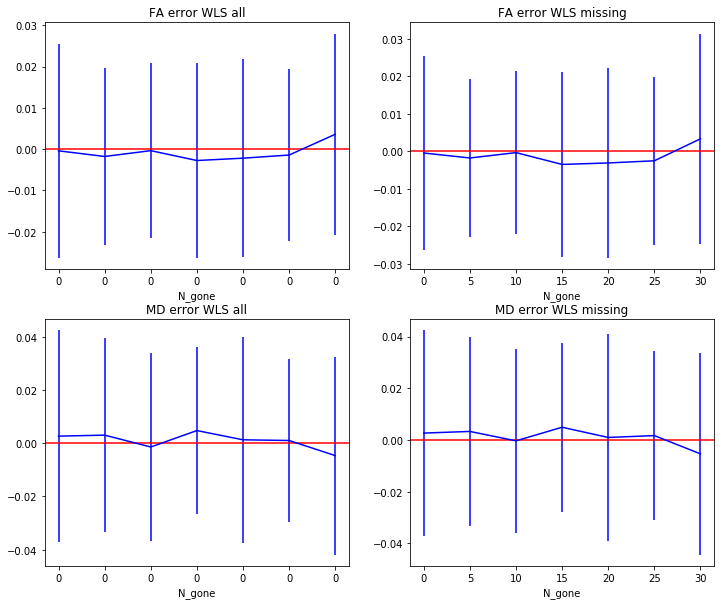

In [297]:
pl.figure(figsize=(12, 10))
pl.subplot(2,2,1)
pl.title('FA error WLS all')
data = [[r[0][0]] for r in results]
data_std = [[r[0][4]] for r in results]
pl.errorbar(range(len(N_artefact)), data, yerr=np.array(data_std), color='blue')
pl.axhline(0, color='red')
pl.xticks(range(len(N_artefact)), '0'*len(N_artefact))
pl.xlabel('N_gone')

pl.subplot(2,2,2)
pl.title('FA error WLS missing')
data = [[r[1][0]] for r in results]
data_std = [[r[1][4]] for r in results]
pl.errorbar(range(len(N_artefact)), data, yerr=np.array(data_std), color='blue')
pl.axhline(0, color='red')
pl.xticks(range(len(N_artefact)), N_artefact)
pl.xlabel('N_gone')

pl.subplot(2,2,3)
pl.title('MD error WLS all')
data = [[r[0][1]] for r in results]
data_std = [[r[0][5]] for r in results]
pl.errorbar(range(len(N_artefact)), data, yerr=np.array(data_std), color='blue')
pl.axhline(0, color='red')
pl.xticks(range(len(N_artefact)), '0'*len(N_artefact))
pl.xlabel('N_gone')

pl.subplot(2,2,4)
pl.title('MD error WLS missing')
data = [[r[1][1]] for r in results]
data_std = [[r[1][5]] for r in results]
pl.errorbar(range(len(N_artefact)), data, yerr=np.array(data_std), color='blue')
pl.axhline(0, color='red')
pl.xticks(range(len(N_artefact)), N_artefact)
pl.xlabel('N_gone')

pl.show()

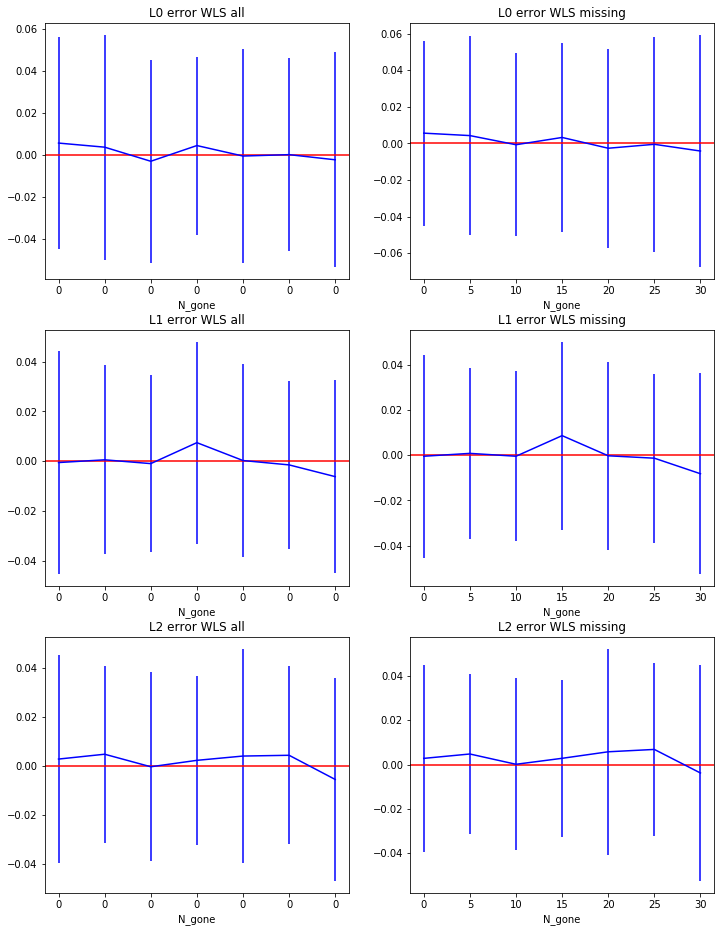

In [298]:
pl.figure(figsize=(12, 16))
pl.subplot(3,2,1)
pl.title('L0 error WLS all')
data = [[r[0][2][0]] for r in results]
data_std = [[r[0][6][0]] for r in results]
pl.errorbar(range(len(N_artefact)), data, yerr=np.array(data_std), color='blue')
pl.axhline(0, color='red')
pl.xticks(range(len(N_artefact)), '0'*len(N_artefact))
pl.xlabel('N_gone')

pl.subplot(3,2,2)
pl.title('L0 error WLS missing')
data = [[r[1][2][0]] for r in results]
data_std = [[r[1][6][0]] for r in results]
pl.errorbar(range(len(N_artefact)), data, yerr=np.array(data_std), color='blue')
pl.axhline(0, color='red')
pl.xticks(range(len(N_artefact)), N_artefact)
pl.xlabel('N_gone')

pl.subplot(3,2,3)
pl.title('L1 error WLS all')
data = [[r[0][2][1]] for r in results]
data_std = [[r[0][6][1]] for r in results]
pl.errorbar(range(len(N_artefact)), data, yerr=np.array(data_std), color='blue')
pl.axhline(0, color='red')
pl.xticks(range(len(N_artefact)), '0'*len(N_artefact))
pl.xlabel('N_gone')

pl.subplot(3,2,4)
pl.title('L1 error WLS missing')
data = [[r[1][2][1]] for r in results]
data_std = [[r[1][6][1]] for r in results]
pl.errorbar(range(len(N_artefact)), data, yerr=np.array(data_std), color='blue')
pl.axhline(0, color='red')
pl.xticks(range(len(N_artefact)), N_artefact)
pl.xlabel('N_gone')

pl.subplot(3,2,5)
pl.title('L2 error WLS all')
data = [[r[0][2][2]] for r in results]
data_std = [[r[0][6][2]] for r in results]
pl.errorbar(range(len(N_artefact)), data, yerr=np.array(data_std), color='blue')
pl.axhline(0, color='red')
pl.xticks(range(len(N_artefact)), '0'*len(N_artefact))
pl.xlabel('N_gone')

pl.subplot(3,2,6)
pl.title('L2 error WLS missing')
data = [[r[1][2][2]] for r in results]
data_std = [[r[1][6][2]] for r in results]
pl.errorbar(range(len(N_artefact)), data, yerr=np.array(data_std), color='blue')
pl.axhline(0, color='red')
pl.xticks(range(len(N_artefact)), N_artefact)
pl.xlabel('N_gone')

pl.show()

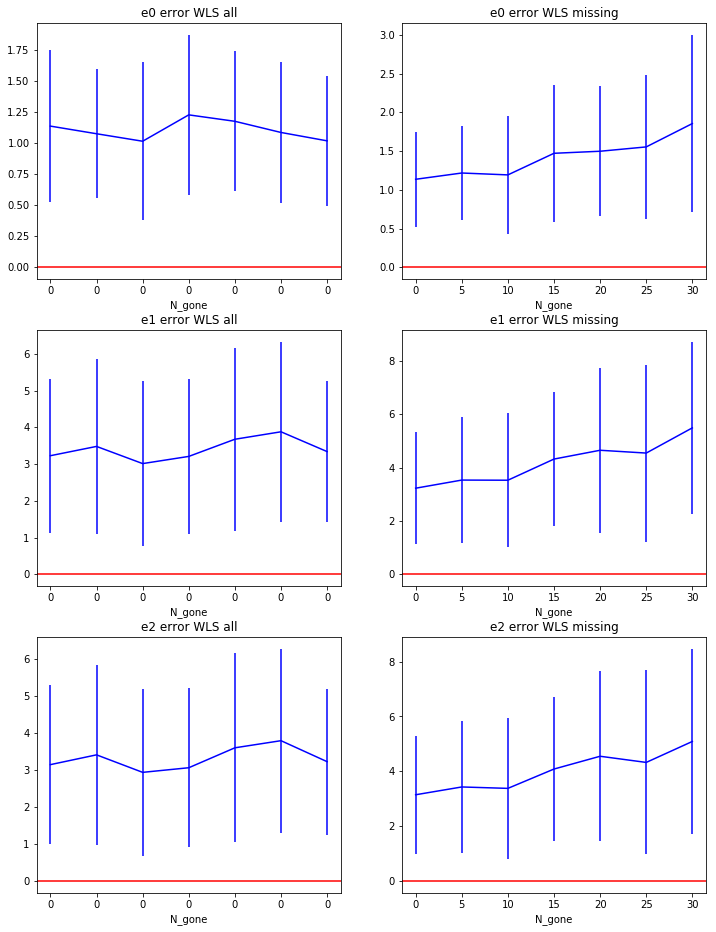

In [299]:
pl.figure(figsize=(12, 16))
pl.subplot(3,2,1)
pl.title('e0 error WLS all')
data = [[r[0][3][0]] for r in results]
data_std = [[r[0][7][0]] for r in results]
pl.errorbar(range(len(N_artefact)), data, yerr=np.array(data_std), color='blue')
pl.axhline(0, color='red')
pl.xticks(range(len(N_artefact)), '0'*len(N_artefact))
pl.xlabel('N_gone')

pl.subplot(3,2,2)
pl.title('e0 error WLS missing')
data = [[r[1][3][0]] for r in results]
data_std = [[r[1][7][0]] for r in results]
pl.errorbar(range(len(N_artefact)), data, yerr=np.array(data_std), color='blue')
pl.axhline(0, color='red')
pl.xticks(range(len(N_artefact)), N_artefact)
pl.xlabel('N_gone')

pl.subplot(3,2,3)
pl.title('e1 error WLS all')
data = [[r[0][3][1]] for r in results]
data_std = [[r[0][7][1]] for r in results]
pl.errorbar(range(len(N_artefact)), data, yerr=np.array(data_std), color='blue')
pl.axhline(0, color='red')
pl.xticks(range(len(N_artefact)), '0'*len(N_artefact))
pl.xlabel('N_gone')

pl.subplot(3,2,4)
pl.title('e1 error WLS missing')
data = [[r[1][3][1]] for r in results]
data_std = [[r[1][7][1]] for r in results]
pl.errorbar(range(len(N_artefact)), data, yerr=np.array(data_std), color='blue')
pl.axhline(0, color='red')
pl.xticks(range(len(N_artefact)), N_artefact)
pl.xlabel('N_gone')

pl.subplot(3,2,5)
pl.title('e2 error WLS all')
data = [[r[0][3][2]] for r in results]
data_std = [[r[0][7][2]] for r in results]
pl.errorbar(range(len(N_artefact)), data, yerr=np.array(data_std), color='blue')
pl.axhline(0, color='red')
pl.xticks(range(len(N_artefact)), '0'*len(N_artefact))
pl.xlabel('N_gone')

pl.subplot(3,2,6)
pl.title('e2 error WLS missing')
data = [[r[1][3][2]] for r in results]
data_std = [[r[1][7][2]] for r in results]
pl.errorbar(range(len(N_artefact)), data, yerr=np.array(data_std), color='blue')
pl.axhline(0, color='red')
pl.xticks(range(len(N_artefact)), N_artefact)
pl.xlabel('N_gone')

pl.show()

# Experimental nonsense to ignore

In [158]:
# test sigma
noiseless = single_tensor(gtab, S0=1, evals=np.array([1,1,1]), evecs=evecs, snr=None)
snrs = [5, 10, 15, 30, 50, 100]
trial = 100
test_sigma = np.zeros((len(snrs), trial))
for isnr,snr in enumerate(snrs):
    for i in range(trial):
        test = single_tensor(gtab, S0=1, evals=np.array([1,1,1]), evecs=evecs, snr=snr)
        noise = test-noiseless
        test_sigma[isnr, i] = noise.std()

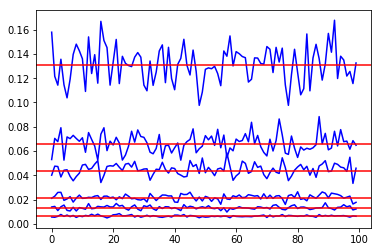

In [173]:
pl.figure()
pl.plot(test_sigma.T, color='blue')
for snr in snrs:
    pl.axhline(np.sqrt((4-np.pi)/2)/snr, color='red')
    
# in words a signal of SNR=x (with dipy definition)
# produces noise with std np.sqrt((4-np.pi)/2)/x
# conforme with rayleigh definition

In [34]:
gt_noiseless = single_tensor(gtab, S0=1, evals=evals, evecs=evecs, snr=None)

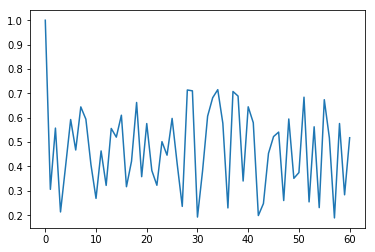

In [41]:
pl.figure()
pl.plot(gt_noiseless)
pl.show()

In [143]:
trial = 100
snr = 30
gt_noisy = np.zeros((61, trial))
# introduce "artefact" by reducng by half the noisy intensity of broken_idx
broken_idx = (10,11,12)
for i in range(trial):
    gt_noisy[:,i] = single_tensor(gtab, S0=1, evals=evals, evecs=evecs, snr=snr)
    gt_noisy[broken_idx,i] *= 0.5

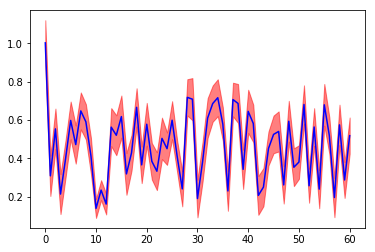

In [144]:
noisy_mean = gt_noisy.mean(axis=1)
noisy_std = gt_noisy.std(axis=1)

pl.figure()
pl.plot(noisy_mean, color='blue')
pl.fill_between(range(noisy_mean.shape[0]), noisy_mean-3*noisy_std, noisy_mean+3*noisy_std, color='red', alpha=0.5)
pl.show()

In [145]:
# noiseless fit
dti_wls = dti.TensorModel(gtab)
fit_wls = dti_wls.fit(gt_noiseless)
print(evals - fit_wls.evals)
print(np.minimum((evecs - fit_wls.evecs).sum(0), (evecs + fit_wls.evecs).sum(0)))
gt_fa = fit_wls.fa
gt_md = fit_wls.md
print(gt_fa)
print(gt_md)

[ 1.51788304e-18  1.51788304e-18 -5.96311195e-19]
[ 8.88178420e-16  1.38777878e-15 -2.41473508e-15]
0.7297312792652378
0.0008333333333333326


In [146]:
gt_noisy_wls_evals = np.zeros((3, trial))
gt_noisy_wls_evecs = np.zeros((3, 3, trial))
gt_noisy_wls_fa = np.zeros((trial))
gt_noisy_wls_md = np.zeros((trial))
for i in range(trial):
    fit_wls = dti_wls.fit(gt_noisy[:,i])
    gt_noisy_wls_evals[:, i] = fit_wls.evals
    gt_noisy_wls_evecs[:, :, i] = fit_wls.evecs
    gt_noisy_wls_fa[i] = fit_wls.fa
    gt_noisy_wls_md[i] = fit_wls.md

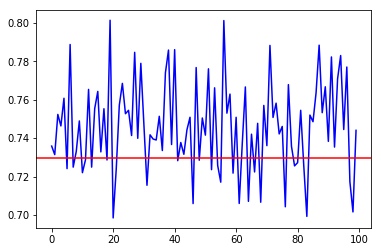

In [147]:
pl.figure()
pl.plot(gt_noisy_wls_fa, color='blue')
pl.axhline(gt_fa, color='red')
pl.show()

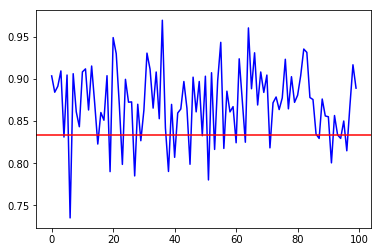

In [148]:
pl.figure()
pl.plot(gt_noisy_wls_md*1e3, color='blue')
pl.axhline(gt_md*1e3, color='red')
pl.show()

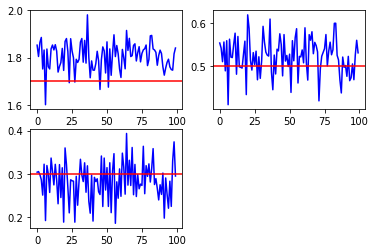

In [149]:
pl.figure()
pl.subplot(2,2,1)
pl.plot(gt_noisy_wls_evals[0]*1e3, color='blue')
pl.axhline(evals[0]*1e3, color='red')
pl.subplot(2,2,2)
pl.plot(gt_noisy_wls_evals[1]*1e3, color='blue')
pl.axhline(evals[1]*1e3, color='red')
pl.subplot(2,2,3)
pl.plot(gt_noisy_wls_evals[2]*1e3, color='blue')
pl.axhline(evals[2]*1e3, color='red')
pl.show()

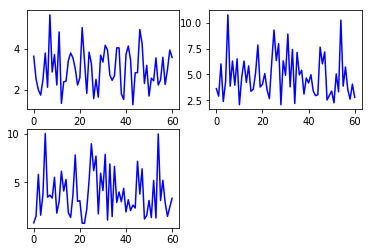

In [151]:
pl.figure()
pl.subplot(2,2,1)
dist_e0 = [dist_deg_antipodal(gt_noisy_wls_evecs[:, 0, i], evecs[:, 0]) for i in range(noisy_mean.shape[0])]
pl.plot(dist_e0, color='blue')
pl.subplot(2,2,2)
dist_e1 = [dist_deg_antipodal(gt_noisy_wls_evecs[:, 1, i], evecs[:, 1]) for i in range(noisy_mean.shape[0])]
pl.plot(dist_e1, color='blue')
pl.subplot(2,2,3)
dist_e2 = [dist_deg_antipodal(gt_noisy_wls_evecs[:, 2, i], evecs[:, 2]) for i in range(noisy_mean.shape[0])]
pl.plot(dist_e2, color='blue')
pl.show()

In [156]:
# summary
print('For SNR = {} (rician)'.format(snr))
print('With {} broken directions ({})'.format(len(broken_idx), broken_idx))
print('FA = {:.3f}   mean-FA = {:.3f}  (std = {:.4f}  {:.1f}%)'.format(gt_fa, gt_noisy_wls_fa.mean(), gt_noisy_wls_fa.std(), 100*gt_noisy_wls_fa.std()/gt_fa))
print('MD = {:.3f}   mean-MD = {:.3f}  (std = {:.4f}  {:.1f}%)'.format(gt_md*1e3, gt_noisy_wls_md.mean()*1e3, gt_noisy_wls_md.std()*1e3, 100*gt_noisy_wls_md.std()/gt_md))
print('l0 = {:.3f}   mean-l0 = {:.3f}  (std = {:.4f}  {:.1f}%)'.format(evals[0]*1e3, gt_noisy_wls_evals[0].mean()*1e3, gt_noisy_wls_evals[0].std()*1e3, 100*gt_noisy_wls_evals[0].std()/evals[0]))
print('l1 = {:.3f}   mean-l1 = {:.3f}  (std = {:.4f}  {:.1f}%)'.format(evals[1]*1e3, gt_noisy_wls_evals[1].mean()*1e3, gt_noisy_wls_evals[1].std()*1e3, 100*gt_noisy_wls_evals[1].std()/evals[1]))
print('l2 = {:.3f}   mean-l2 = {:.3f}  (std = {:.4f}  {:.1f}%)'.format(evals[2]*1e3, gt_noisy_wls_evals[2].mean()*1e3, gt_noisy_wls_evals[2].std()*1e3, 100*gt_noisy_wls_evals[2].std()/evals[2]))
print('              err-e0 = {:.3f}  (std = {:.4f})'.format(np.array(dist_e0).mean(), np.array(dist_e0).std()))
print('              err-e1 = {:.3f}  (std = {:.4f})'.format(np.array(dist_e1).mean(), np.array(dist_e1).std()))
print('              err-e2 = {:.3f}  (std = {:.4f})'.format(np.array(dist_e2).mean(), np.array(dist_e2).std()))
 

For SNR = 30 (rician)
With 3 broken directions ((10, 11, 12))
FA = 0.730   mean-FA = 0.746  (std = 0.0234  3.2%)
MD = 0.833   mean-MD = 0.871  (std = 0.0427  5.1%)
l0 = 1.700   mean-l0 = 1.806  (std = 0.0583  3.4%)
l1 = 0.500   mean-l1 = 0.524  (std = 0.0418  8.4%)
l2 = 0.300   mean-l2 = 0.283  (std = 0.0448  14.9%)
              err-e0 = 3.028  (std = 0.9727)
              err-e1 = 4.832  (std = 2.0520)
              err-e2 = 3.858  (std = 2.3497)
